In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import torch

import metatensor.torch as mts
from metatensor.torch import TensorMap, TensorBlock, Labels
from metatrain.gap.model import _FPS

from featomic.torch import systems_to_torch

from gpr import get_targets_from_xyz, PolynomialKernel, SoapCalculator, KernelCalculator, GPR

In [35]:
import yaml
with open('options.yaml', 'r') as file:
    options = yaml.safe_load(file)

In [36]:
torch.set_default_dtype(getattr(torch, options["torch"]["dtype"]))

In [37]:
# Read the train and test frames.
frames_train = ase.io.read(options["training_set"]["systems"], ":")
frames_val = ase.io.read(options["validation_set"]["systems"], ":")
train_id = list(range(len(frames_train)))
val_id = list(range(len(frames_train), len(frames_train) + len(frames_val)))

# Parse the energies from the xyz
train_targets = {
    "energy": get_targets_from_xyz(
        frames_train,
        train_id,
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
        use_gradients=options["training"]["use_gradients"],
        energy_key=options["training_set"]["targets"]["energy"]["key"],
        force_key=options["training_set"]["targets"]["forces"]["key"],
    )
}
val_targets = {
    "energy": get_targets_from_xyz(
        frames_val,
        val_id,
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
        use_gradients=options["training"]["use_gradients"],
        energy_key=options["validation_set"]["targets"]["energy"]["key"],
        force_key=options["validation_set"]["targets"]["forces"]["key"],
    )
}

# Initialize calculators
soap_calculator = SoapCalculator(options["model"]["soap"])
kernel_fn = PolynomialKernel(degree=options["model"]["krr"]["degree"])

In [38]:
# Convert the frames into auto-differentiable systems objects
systems_train = [
    sys.to(
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    )
    for sys in systems_to_torch(frames_train)
]
for sys in systems_train:
    sys.positions.requires_grad = True
    sys.cell.requires_grad = True

systems_val = [
    sys.to(
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    )
    for sys in systems_to_torch(frames_val)
]
for sys in systems_val:
    sys.positions.requires_grad = True
    sys.cell.requires_grad = True

# Now compute SOAP, select some sparse points, and compute the kernel
soap_vector_train = soap_calculator(
    systems_train,
    gradients=(
        ["positions"] if len(train_targets["energy"][0].gradients()) > 0 else None
    ),
)

if options["model"]["krr"]["num_sparse_points"] is None:
    num_sparse_points = len(soap_vector_train[0])
    print(f"using {num_sparse_points} sparse points")
else:
    num_sparse_points = options["model"]["krr"]["num_sparse_points"]
    assert num_sparse_points <= len(
        soap_vector_train[0]
    ), f"can only have a maximum of {len(soap_vector_train[0])} sparse points"
fps = _FPS(n_to_select=num_sparse_points)

# Select sparse points
soap_vector_train_fps = mts.remove_gradients(fps.fit_transform(soap_vector_train))

# Define the kernel calculator. This pre-computes k_mm.
kernel_calculator = KernelCalculator(
    kernel_fn=kernel_fn, sparse_points=soap_vector_train_fps
)
gpr = GPR(
    atomic_types=options["model"]["atomic_types"],
    kernel_calculator=kernel_calculator,
    dtype=getattr(torch, options["torch"]["dtype"]),
    device=options["torch"]["device"],
)

using 495 sparse points


/home/apaulish/Documents/code/joe_davide/gap/lib/python3.10/site-packages/skmatter/_selection.py:281: UserWarning: Score threshold of 1e-12 reached.Terminating search at 445 / 495.
  warnings.warn(


In [47]:
# Regularizer - energy
if options["training"]["alpha_energy"]["read_from"] is None:  # homoscedastic energy
    alpha_energy = options["training"]["alpha_energy"]["value"]
else:
    energy_errors = np.loadtxt(options["training"]["alpha_energy"]["read_from"])
    #energy_errors = [0.15 for i in range(len(energy_errors))]
    alpha = 0.85 #0.085
    alpha_energy = alpha * torch.tensor(
        energy_errors,
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    )

# Regularizer - energy grads
if options["training"]["alpha_energy_grad"]["read_from"] is None:  # homoscedastic energy
    alpha_energy_grad = options["training"]["alpha_energy_grad"]["value"]
else:
    #0.15
    alpha_energy_grad = 1. * torch.tensor(
        np.loadtxt(options["training"]["alpha_energy_grad"]["read_from"]), #force_errors, 
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    ).reshape(-1, 3)

print("alpha_energy = ", alpha_energy)
print("alpha_energy_grad = ", alpha_energy_grad)

# Compute the kernel and aggregate over samples
k_nm = kernel_calculator(soap_vector_train)
k_nm_reduced = mts.sum_over_samples(k_nm, ["atom", "center_type"])

# Copy the targets for normalising
targets_baselined = {k: v.copy() for k, v in train_targets.items()}

# Fit the GPR model
gpr.fit(
    systems=systems_train,
    system_id=train_id,
    k_nm=k_nm_reduced,
    targets=targets_baselined,
    alpha_energy=alpha_energy,
    alpha_energy_grad=alpha_energy_grad,
)

alpha_energy =  0.001
alpha_energy_grad =  0.001


In [48]:
# Convert the frames into auto-differentiable systems objects
systems_train = [
    sys.to(
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    )
    for sys in systems_to_torch(frames_train)
]
for sys in systems_train:
    sys.positions.requires_grad = True
    sys.cell.requires_grad = True

systems_val = [
    sys.to(
        dtype=getattr(torch, options["torch"]["dtype"]),
        device=options["torch"]["device"],
    )
    for sys in systems_to_torch(frames_val)
]
for sys in systems_val:
    sys.positions.requires_grad = True
    sys.cell.requires_grad = True

# k_tt_train = kernel_fn(
#         soap_calculator(
#             systems_train,
#             gradients=None,
#     ), 
#         soap_calculator(
#             systems_train,
#             gradients=None,
#     )
# )
# k_tt_val = kernel_fn(
#         soap_calculator(
#             systems_val,
#             gradients=None,
#     ), 
#         soap_calculator(
#             systems_val,
#             gradients=None,
#     )
# )

# Make predictions
train_predictions = gpr(
    systems_train,
    train_id,
    k_tm=kernel_calculator(
        soap_calculator(
            systems_train,
            gradients=["positions"] if options["training"]["use_gradients"] else None,
        )
    ),
    predict_gradients=options["training"]["use_gradients"],
    predict_std_energy=options["training"]["predict_std_energy"],
    predict_std_energy_grad=options["training"]["predict_std_energy_grad"],
    #k_tt=k_tt_train
)
val_predictions = gpr(
    systems_val,
    val_id,
    k_tm=kernel_calculator(
        soap_calculator(
            systems_val,
            gradients=["positions"] if options["training"]["use_gradients"] else None,
        )
    ),
    predict_gradients=options["training"]["use_gradients"],
    predict_std_energy=options["training"]["predict_std_energy"],
    predict_std_energy_grad=options["training"]["predict_std_energy_grad"],
    #k_tt=k_tt_val
)
mts.equal_metadata_raise(train_targets["energy"], train_predictions["energy"])
mts.equal_metadata_raise(val_targets["energy"], val_predictions["energy"])

# Get the data arrays - energies (NOTE: plotting energy per atom here)
e_targ_train = train_targets["energy"][0].values.flatten().numpy() / np.array(
    [len(frame) for frame in frames_train]
)
e_pred_train = train_predictions["energy"][
    0
].values.flatten().detach().numpy() / np.array([len(frame) for frame in frames_train])
e_targ_val = val_targets["energy"][0].values.flatten().numpy() / np.array(
    [len(frame) for frame in frames_val]
)
e_pred_val = val_predictions["energy"][0].values.flatten().detach().numpy() / np.array(
    [len(frame) for frame in frames_val]
)

# Get the data arrays - forces. NOTE: we are predicting the negative of the forces here!
if options["training"]["use_gradients"]:
    minus_f_targ_train = (
        train_targets["energy"][0].gradient("positions").values.flatten().numpy()
    )
    minus_f_pred_train = (
        train_predictions["energy"][0]
        .gradient("positions")
        .values.flatten()
        .detach()
        .numpy()
    )
    minus_f_targ_val = (
        val_targets["energy"][0].gradient("positions").values.flatten().numpy()
    )
    minus_f_pred_val = (
        val_predictions["energy"][0]
        .gradient("positions")
        .values.flatten()
        .detach()
        .numpy()
    )

In [49]:
n_train_structures = len(e_pred_train)
n_val_structures = len(e_pred_val)

n_train_structures, n_val_structures

(60, 132)

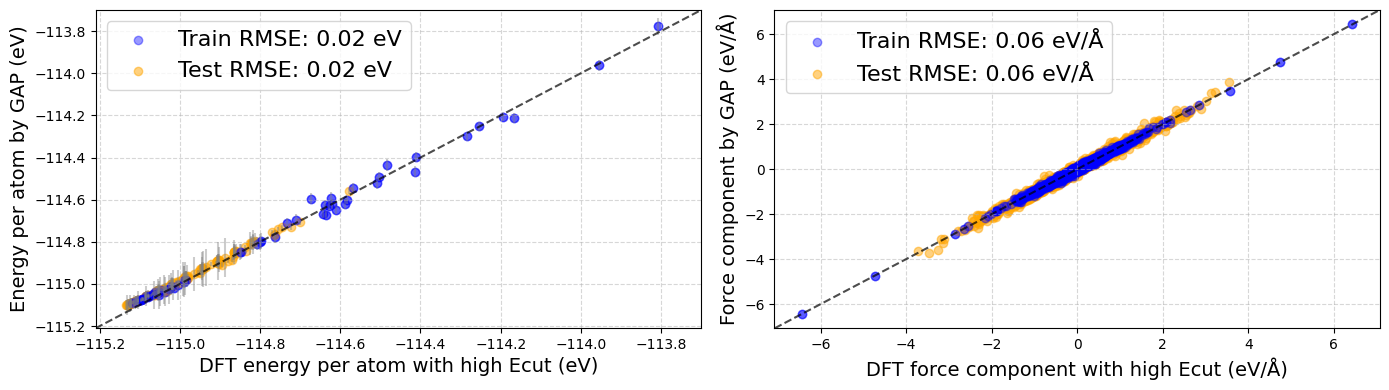

In [50]:
# Compute RMSE
rmse_energy_train = np.sqrt(np.mean((e_targ_train - e_pred_train) ** 2))
rmse_energy_val = np.sqrt(np.mean((e_targ_val - e_pred_val) ** 2))
rmse_force_train = np.sqrt(np.mean((minus_f_targ_train - minus_f_pred_train) ** 2))
rmse_force_val = np.sqrt(np.mean((minus_f_targ_val - minus_f_pred_val) ** 2))


# Parity plot. Plot the actual forces, so take the negative of the targets and predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Errors
if options["training"]["predict_std_energy"]:
    pred_std_train =  train_predictions["std_energy"][0].values.detach().numpy().reshape(n_train_structures,)
    pred_std_val =  val_predictions["std_energy"][0].values.detach().numpy().reshape(n_val_structures,)

    # Scaling
    scaling_factor = 1
    pred_std_train_scaled = pred_std_train / scaling_factor
    pred_std_val_scaled = pred_std_val / scaling_factor

    # Add error bars on energy values
    axes[0].errorbar(
        e_targ_train,
        e_pred_train,
        yerr=pred_std_train_scaled,
        fmt="none",
        ecolor="gray",
        alpha=0.4,
    )
    axes[0].errorbar(
        e_targ_val,
        e_pred_val,
        yerr=pred_std_val_scaled,
        fmt="none",
        ecolor="gray",
        alpha=0.4,
    )

axes[0].scatter(e_targ_train, e_pred_train, c="blue", alpha=0.4, label=f"Train RMSE: {rmse_energy_train:.1} eV")
axes[0].scatter(e_targ_val, e_pred_val, c="orange", alpha=0.5, label=f"Test RMSE: {rmse_energy_val:.1} eV")
axes[0].scatter(e_targ_train, e_pred_train, c="blue", alpha=0.4)

axes[0].grid(alpha=0.5, linestyle="--")
if options["training"]["use_gradients"]:
    axes[1].scatter(-minus_f_targ_train, -minus_f_pred_train, c="blue", alpha=0.4, label=f"Train RMSE: {rmse_force_train:.1} eV/Å")
    axes[1].scatter(-minus_f_targ_val, -minus_f_pred_val, c="orange", alpha=0.5, label=f"Test RMSE: {rmse_force_val:.1} eV/Å")
    axes[1].scatter(-minus_f_targ_train, -minus_f_pred_train, c="blue", alpha=0.4)
    axes[1].grid(alpha=0.5, linestyle="--")

# Format
[ax.axline([0, 0], [1, 1], linestyle="--", c="k", alpha=0.7) for ax in axes]
axes_lo = np.min(np.concatenate([e_targ_train, e_targ_val])) - 0.1
axes_hi = np.max(np.concatenate([e_targ_train, e_targ_val])) + 0.1

axes_lo = -115.21
axes_hi = -113.7
axes[0].set_xlim([axes_lo, axes_hi])
axes[0].set_ylim([axes_lo, axes_hi])

axes[0].set_xlabel("DFT energy per atom with high Ecut (eV)", fontsize=14) 
axes[1].set_xlabel("DFT force component with high Ecut (eV/Å)", fontsize=14) 
axes[0].set_ylabel("Energy per atom by GAP (eV)", fontsize=14)
axes[1].set_ylabel("Force component by GAP (eV/Å)", fontsize=14)

# legend top left
axes[0].legend(loc="upper left", fontsize=16)
axes[1].legend(loc="upper left", fontsize=16)

plt.tight_layout()
# save high quality image
#plt.savefig("images/n60_hom_high_fid.png", dpi=300)
#plt.savefig("images/sparse800_het_EF_n192_001_01.png", dpi=300)
#fig.savefig("images/n200_hom_mix_fid.png")

In [51]:
# Compute actual errors
actual_error = np.abs(e_targ_val - e_pred_val)

# Count how many times the predicted std is smaller than the actual error
underconfident_cases = np.sum(2.58 * pred_std_val_scaled < actual_error)
total_cases = len(actual_error)

# Compute fraction
underconfidence_fraction = underconfident_cases / total_cases

print(f"Fraction of Underconfident Predictions: {underconfidence_fraction:.3f}")

Fraction of Underconfident Predictions: 0.023


In [52]:
# compute correlation between predicted and actual error
import numpy as np
from scipy.stats import pearsonr

#remove nan values
pred_std = pred_std_val[~np.isnan(pred_std_val)]
e_targ_val = e_targ_val[~np.isnan(pred_std_val)]
e_pred_val = e_pred_val[~np.isnan(pred_std_val)]

# #pred_std = pred_std_val
# actual_error = np.abs(e_targ_val - e_pred_val)

# # Assuming `pred_std` is the predicted standard deviation
# # and `actual_error` is the actual absolute error
# correlation, _ = pearsonr(2 * pred_std, np.abs(e_targ_val - e_pred_val))

# #higher correlation (closer to 1) 
# print(f"Pearson Correlation: {correlation:.3f}")
# np.corrcoef(e_targ_val - e_pred_val, 2*pred_std_val)


0.04


Text(0.5, 1.0, 'Predicted std vs Absolute error')

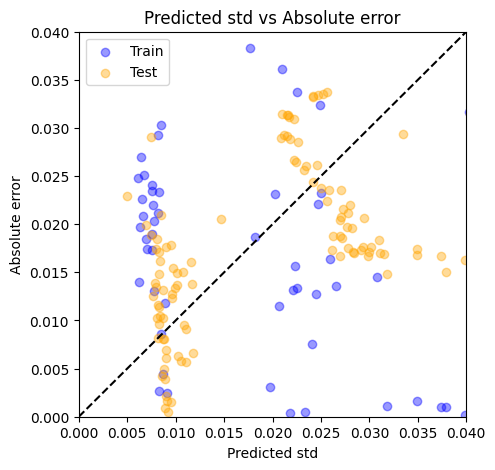

In [53]:
# plot pred_std vs actual rmse error
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(pred_std_train, np.abs(e_targ_train - e_pred_train), c="blue", alpha=0.4, label = "Train")

ax.scatter(pred_std_val, np.abs(e_targ_val - e_pred_val), c="orange", alpha=0.4, label = "Test")
ax.legend()
# add diagonal line
max_value = 0.04 #np.max(np.concatenate([ np.abs(e_targ_train - e_pred_train), np.abs(e_targ_val - e_pred_val)]))
print(max_value)
ax.axline([0, 0], [max_value, max_value], linestyle="--", c="k")
ax.set_xlim([0, max_value])
ax.set_ylim([0, max_value])
ax.set_xlabel("Predicted std")
ax.set_ylabel("Absolute error")
ax.set_title("Predicted std vs Absolute error")
#fig.savefig("images/pred_std_vs_abs_error_hom_mix.png")

In [54]:
# from scipy.stats import binned_statistic

# bins = np.linspace(min(pred_std), max(pred_std), 10)  # 10 bins
# bin_means, _, _ = binned_statistic(pred_std, actual_error, statistic="mean", bins=bins)

# plt.plot(bins[:-1], bin_means, 'o-', label="Actual Error vs. Predicted Std")
# plt.plot(bins[:-1], bins[:-1], '--', label="Ideal Calibration")  # y = x line
# plt.xlabel("Predicted Std")
# plt.ylabel("Actual Error")
# plt.legend()
# plt.show()